# Recommender Playlists

Recommend songs based on track features and current playlists using ML algorithms.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

## Import Data

- Artist and track data was pulled using the Spotify API via the spotipy package
- Data was saved in pickle format using music_data.py and data_functions.py modules
- The data can now be quickly read by multiple workflows

In [73]:
top_artist_df = pd.read_pickle("spotify/top_artists.pkl")
followed_artists_df = pd.read_pickle("spotify/followed_artists.pkl")
top_tracks_df = pd.read_pickle("spotify/top_tracks.pkl")
saved_tracks_df = pd.read_pickle("spotify/saved_tracks.pkl")
playlist_tracks_df = pd.read_pickle("spotify/playlist_tracks.pkl")

In [74]:
# Remove duplicates on track id
playlist_tracks_df = playlist_tracks_df.drop_duplicates(subset='id', keep="first").reset_index()

In [75]:
playlist_tracks_df.head()

,index,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,...,track_href,analysis_url,time_signature,analyzer_version,platform,detailed_status,status_code,timestamp,analysis_time,input_process
0,0,6fgbQt13JlpN59PytgTMsA,Snow (Hey Oh),61,audio_features,False,False,334667,1,1,...,https://api.spotify.com/v1/tracks/6fgbQt13JlpN...,https://api.spotify.com/v1/audio-analysis/6fgb...,4,4.0.0,Linux,OK,0,1444570278,13.83120,libvorbisfile L+R 44100->22050
1,1,3JOdLCIBzQYwHIvpN3isVf,Grand Theft Autumn / Where Is Your Boy,62,audio_features,False,False,191373,1,3,...,https://api.spotify.com/v1/tracks/3JOdLCIBzQYw...,https://api.spotify.com/v1/audio-analysis/3JOd...,4,4.0.0,Linux,OK,0,1445050760,7.72903,libvorbisfile L+R 44100->22050
2,2,7pAT4dOUzjq8Ziap5ShIqC,Where'd You Go (feat. Holly Brook & Jonah Matr...,58,audio_features,False,True,231867,1,6,...,https://api.spotify.com/v1/tracks/7pAT4dOUzjq8...,https://api.spotify.com/v1/audio-analysis/7pAT...,4,4.0.0,Linux,OK,0,1572297760,7.12791,libvorbisfile L+R 44100->22050
3,3,1b7vg5T9YKR3NNqXfBYRF7,Check Yes Juliet,53,audio_features,False,False,220133,1,3,...,https://api.spotify.com/v1/tracks/1b7vg5T9YKR3...,https://api.spotify.com/v1/audio-analysis/1b7v...,4,4.0.0,Linux,OK,0,1444489788,9.60749,libvorbisfile L+R 44100->22050
4,4,12qZHAeOyTf93YAWvGDTat,All The Small Things,0,audio_features,False,False,168000,1,8,...,https://api.spotify.com/v1/tracks/12qZHAeOyTf9...,https://api.spotify.com/v1/audio-analysis/12qZ...,4,4.0.0,Linux,OK,0,1444553514,7.52174,libvorbisfile L+R 44100->22050


## Create Ratings

I want to avoid time labelling my data, the best way to form recommendations would be to rate all my playlist songs from 1-10 and form a regression problem. I'm skipping this as I have a 'Best Of' playlist folder, so can turn this into a classifcation problem.

- Everything before 'Everlong - Acoustic Version' is my favourites, classify these as 1
- Classify the rest as 0

In [76]:
playlist_tracks_df.loc[playlist_tracks_df['name'] == 'Everlong - Acoustic Version']

,index,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,...,track_href,analysis_url,time_signature,analyzer_version,platform,detailed_status,status_code,timestamp,analysis_time,input_process
640,1060,3QmesrvdbPjwf7i40nht1D,Everlong - Acoustic Version,69,audio_features,False,False,250907,1,16,...,https://api.spotify.com/v1/tracks/3QmesrvdbPjw...,https://api.spotify.com/v1/audio-analysis/3Qme...,4,4.0.0,Linux,OK,0,1571740482,7.94294,libvorbisfile L+R 44100->22050


In [77]:
ratings = [1 for _ in range(639)] + [0 for _ in range(len(playlist_tracks_df) - 639)]
playlist_tracks_df['ratings'] = ratings

In [78]:
# Training data
X = playlist_tracks_df[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 
                        'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence',
                        'popularity', 'duration_ms', 'explicit', 'time_signature']]
y = playlist_tracks_df['ratings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
582,0.000724,0.417,223809,0.981,0.000003,6,0.2100,-3.607,1,0.1370,168.056,0.367
48,0.835000,0.609,233720,0.378,0.000000,4,0.2800,-9.828,1,0.4380,100.418,0.515
1772,0.632000,0.545,249493,0.662,0.000002,5,0.1200,-7.530,0,0.0297,160.058,0.920
964,0.374000,0.528,210661,0.610,0.000073,5,0.2110,-6.564,1,0.0287,130.108,0.304
2213,0.791000,0.745,227872,0.397,0.000029,11,0.1010,-9.084,1,0.0283,93.947,0.516
...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.194000,0.529,232120,0.740,0.000000,11,0.0711,-3.309,1,0.0610,199.582,0.762
1095,0.752000,0.110,138960,0.265,0.944000,0,0.1040,-12.400,0,0.0351,80.626,0.198
1130,0.207000,0.483,198946,0.351,0.003610,6,0.0960,-10.386,0,0.0306,76.808,0.155
1294,0.000005,0.301,260387,0.940,0.914000,5,0.3300,-8.671,0,0.0897,196.971,0.321


## ML Time

- Feature rankings
- No need to PCA we don't assume a linear relationship between variables and we want our components to be interpretable
- ML models for classification (logistic regression, random forest, xgboost, knn)

### Feature Rankings

Optimal number of features: 8


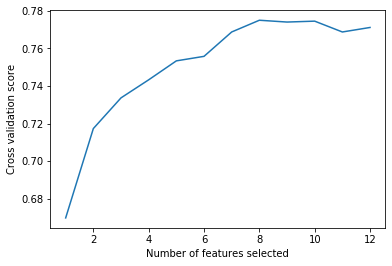

In [79]:
# Cross-validation for number of features
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(2))
rfecv.fit(X_train, y_train)

print(f'Optimal number of features: {rfecv.n_features_}')

plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.show()

In [80]:
# Analyze feature importances
rfc = RandomForestClassifier(n_estimators = 1000, max_depth=4, max_features=12, random_state=42)  # 8 is optimal but few features anyway
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in range(len(importances)):
    print(f"{i+1}. {X_train.columns[i]} {importances[indices[i]]}")

Feature ranking:
1. acousticness 0.38308460475831996
2. danceability 0.16528587473278158
3. duration_ms 0.09373692393672925
4. energy 0.08207596447668478
5. instrumentalness 0.05811864924970732
6. key 0.04617210657842682
7. liveness 0.039217043056691665
8. loudness 0.03491471913000703
9. mode 0.032979230553643206
10. speechiness 0.028127974258075505
11. tempo 0.027895728911230586
12. valence 0.008391180357702399


### Logistic Regression

In [84]:
# Logistic Regression

# Rescale features from 0 to 1
minmax_scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(minmax_scaler.fit_transform(X_train), columns=X_train.columns)

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85       387
           1       0.00      0.00      0.00       133

    accuracy                           0.74       520
   macro avg       0.37      0.50      0.43       520
weighted avg       0.55      0.74      0.64       520



/Users/anthony/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest

In [92]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 1000, max_depth=4, max_features=12, random_state=42)
rfc_gcv_parameters = {'max_features': [4, 7, 8, 10], 
                       'min_samples_leaf': [1, 3, 5, 8], 
                       'max_depth': [3, 5, 8]}
rfe_gcv = GridSearchCV(rfc, rfc_gcv_parameters, n_jobs=-1, cv=StratifiedKFold(2), verbose=1)
rfe_gcv.fit(X_train, y_train)
rfe_gcv.best_estimator_, rfe_gcv.best_score_

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.1min finished


(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=8, max_features=7,
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=3, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=1000,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 0.7730769230769231)

In [93]:
print(classification_report(y_test, rfe_gcv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       387
           1       0.35      0.07      0.11       133

    accuracy                           0.73       520
   macro avg       0.55      0.51      0.48       520
weighted avg       0.65      0.73      0.65       520



### XGBoost

In [96]:
# XGBoost Classifier
xgb = XGBClassifier(n_estimators = 1000, max_depth=4, random_state=42)
xgb_gcv_parameters = {'eta': [0.3, 0.4, 0.5],
                      'min_child_weight': [0.3, 0.5, 0.8, 1], 
                      'max_depth': [3, 5, 6, 8]}
xgb_gcv = GridSearchCV(xgb, xgb_gcv_parameters, n_jobs=-1, cv=StratifiedKFold(2), verbose=1)
xgb_gcv.fit(X_train, y_train)
xgb_gcv.best_estimator_, xgb_gcv.best_score_

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.7min finished
/Users/anthony/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:22:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
               gpu_id=-1, importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=8,
               min_child_weight=0.3, missing=nan, monotone_constraints='()',
               n_estimators=1000, n_jobs=8, num_parallel_tree=1,
               objective='binary:logistic', random_state=42, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', use_label_encoder=True,
               validate_parameters=1, verbosity=None),
 0.7475961538461539)

In [97]:
print(classification_report(y_test, xgb_gcv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       387
           1       0.43      0.25      0.32       133

    accuracy                           0.73       520
   macro avg       0.60      0.57      0.57       520
weighted avg       0.69      0.72      0.70       520



### KNN

In [99]:
# KNN Classifier
knn = KNeighborsClassifier(n_jobs=-1)
knn_gcv_params = {'n_neighbors': range(1, 10)}

knn_gcv = GridSearchCV(knn, knn_gcv_params, cv=StratifiedKFold(2), n_jobs=-1, verbose=True)
knn_gcv.fit(X_train, y_train)
knn_gcv.best_params_, knn_gcv.best_score_

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.5s finished


({'n_neighbors': 6}, 0.7399038461538462)

In [100]:
print(classification_report(y_test, xgb_gcv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       387
           1       0.43      0.25      0.32       133

    accuracy                           0.73       520
   macro avg       0.60      0.57      0.57       520
weighted avg       0.69      0.72      0.70       520



# Recommendations

- Looks like XGBoost classifier performs the best for me (as expected), let's see what it recommends should be in "Best Of"
- Use recommendation_tracks_df as the evaluation dataset

In [101]:
playlist_tracks_df

Index(['index', 'id', 'name', 'popularity', 'type', 'is_local', 'explicit',
       'duration_ms', 'disc_number', 'track_number', 'artist_id',
       'artist_name', 'album_artist_id', 'album_artist_name', 'album_id',
       'album_name', 'album_release_date', 'album_tracks', 'album_type',
       'added_at', 'added_by', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'uri', 'track_href', 'analysis_url',
       'time_signature', 'analyzer_version', 'platform', 'detailed_status',
       'status_code', 'timestamp', 'analysis_time', 'input_process',
       'ratings'],
      dtype='object')

In [110]:
playlist_tracks_df['time_signature']

0       4
1       4
2       4
3       4
4       4
       ..
2595    4
2596    4
2597    4
2598    4
2599    4
Name: time_signature, Length: 2600, dtype: int64